<a href="https://colab.research.google.com/github/Dhruv-2020EE30592/EECE-5644/blob/main/Assignment-4/Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import os

from sklearn.svm import SVC
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.base import clone
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_curve, auc, classification_report, log_loss

import torch
import torch.nn as nn
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import pylab

# Question 1

In [ ]:
# Generating samples

def generate_samples(N):
  P_minus1 = 0.5
  P_plus1 = 0.5

  r_minus1, r_plus1 = 2, 4
  sigma = 1

  samples = np.zeros((N, 2))
  labels = np.random.choice([-1, 1], size=N, p=[P_minus1, P_plus1])

  for i in range(N):
    if labels[i] == -1:
      r = r_minus1
    else:
      r = r_plus1
    theta = np.random.uniform(-np.pi, np.pi)
    noise = np.random.normal(0, sigma, 2)
    samples[i] = r * np.array([np.cos(theta), np.sin(theta)]) + noise

  return samples, labels

In [ ]:
# Visualize samples

def visualize_samples(D_samples, L_samples, word):
  class_minus1 = D_samples[L_samples == -1]
  class_plus1 = D_samples[L_samples == 1]

  plt.figure(figsize=(6, 6))
  plt.scatter(class_minus1[:, 0], class_minus1[:, 1], color='red', label='Class -1', alpha=0.3)
  plt.scatter(class_plus1[:, 0], class_plus1[:, 1], color='blue', label='Class +1', alpha=0.3)

  plt.title(f'2D Scatter Plot of {word} Samples', fontsize=14)
  plt.xlabel('X1', fontsize=12)
  plt.ylabel('X2', fontsize=12)
  plt.legend()
  plt.grid(alpha=0.3)
  plt.axis('equal')
  plt.show()

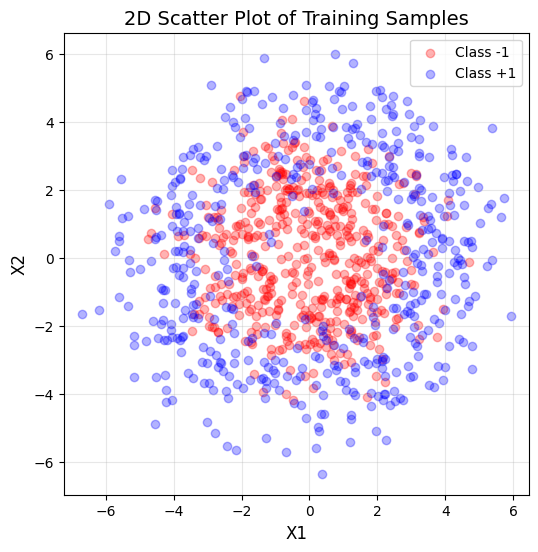

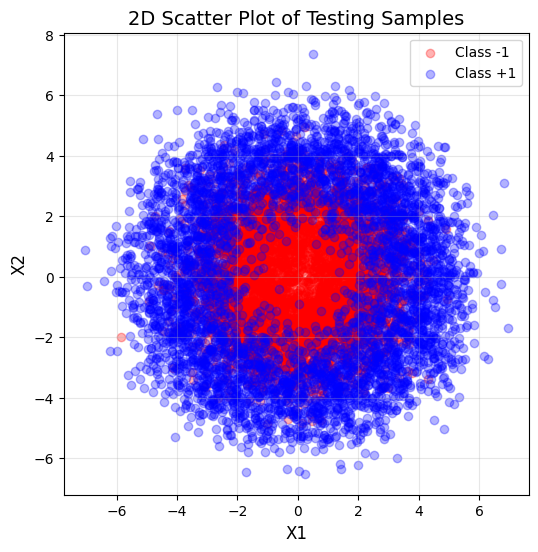

In [ ]:
np.random.seed(42)

D_train, L_train = generate_samples(1000)
visualize_samples(D_train, L_train, 'Training')

D_test, L_test = generate_samples(10000)
visualize_samples(D_test, L_test, 'Testing')

In [ ]:
# SVM Model

def train_svm_rbf(x_train, y_train):
  param_grid = {
    'C': np.logspace(-2, 2, num=5),
    'gamma': np.logspace(-2, 2, num=5)
  }

  svm = SVC(kernel='rbf', random_state=42)

  grid_search = GridSearchCV(svm, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
  grid_search.fit(x_train, y_train)

  visualize_cv_results_svm(grid_search, param_grid)
  best_model = grid_search.best_estimator_
  best_params = grid_search.best_params_
  return best_model, best_params

def visualize_cv_results_svm(grid_search, param_grid):
  results = pd.DataFrame(grid_search.cv_results_)
  scores = results.pivot(index=f'param_C', columns=f'param_gamma', values='mean_test_score')

  plt.figure(figsize=(10, 8))
  sns.heatmap(scores, annot=True, fmt=".4f", cmap="viridis", xticklabels=param_grid['gamma'], yticklabels=param_grid['C'])
  plt.title("SVM Cross-Validation Accuracy")
  plt.xlabel("Gamma")
  plt.ylabel("C")
  plt.show()

  print("Best Parameters:", grid_search.best_params_)
  print("Best Cross-Validation Accuracy: {:.4f}".format(grid_search.best_score_))

def test_svm(model, x_test, y_test):
  y_pred = model.predict(x_test)
  test_accuracy = accuracy_score(y_test, y_pred)
  report = classification_report(y_test, y_pred)
  plot_decision_boundary_svm(model, x_test, y_test, title="SVM Decision Boundary on Test Data")

  print(f"SVM Test Accuracy: {test_accuracy:.4f}")
  print(f"Estimated Probability of Error: {1-test_accuracy:.4f}")
  print("Classification Report:\n", report)
  return test_accuracy, report

def plot_decision_boundary_svm(model, x, y, title="Decision Boundary"):
  class_minus1 = x[y == -1]
  class_plus1 = x[y == 1]

  x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
  y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

  Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)

  plt.figure(figsize=(10, 8))
  plt.scatter(class_minus1[:, 0], class_minus1[:, 1], color='red', label='Class -1', alpha=0.3)
  plt.scatter(class_plus1[:, 0], class_plus1[:, 1], color='blue', label='Class +1', alpha=0.3)
  plt.contour(xx, yy, Z, levels=[0], colors='black', linewidths=2)
  plt.grid(True)
  plt.title(title)
  plt.xlabel("Feature 1")
  plt.ylabel("Feature 2")
  plt.show()

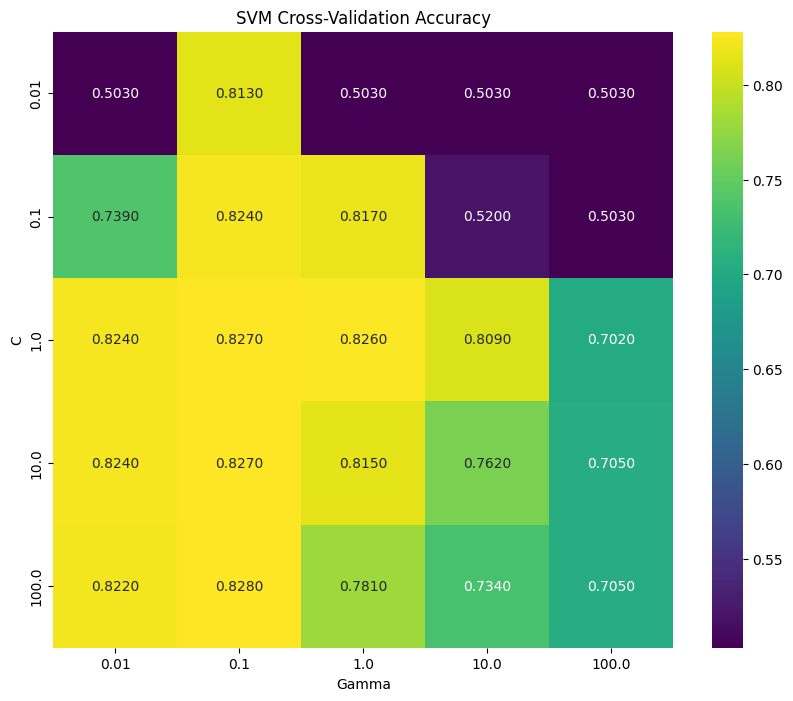

Best Parameters: {'C': 100.0, 'gamma': 0.1}
Best Cross-Validation Accuracy: 0.8280


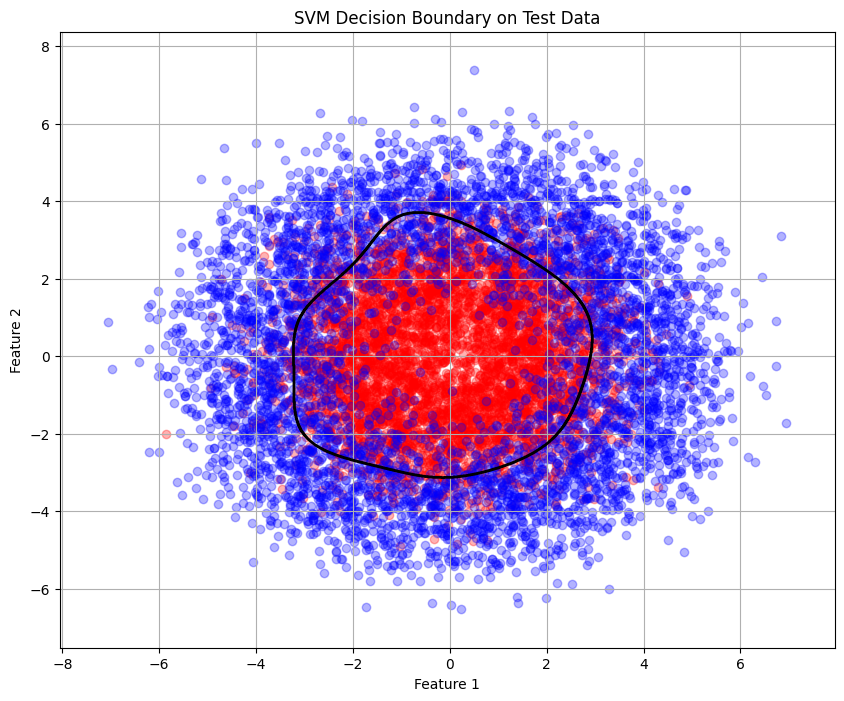

SVM Test Accuracy: 0.8269
Estimated Probability of Error: 0.1731
Classification Report:
               precision    recall  f1-score   support

          -1       0.83      0.83      0.83      5099
           1       0.82      0.82      0.82      4901

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



In [ ]:
svm_model, svm_best_params = train_svm_rbf(D_train, L_train)
svm_test_accuracy, svm_classification_report = test_svm(svm_model, D_test, L_test)

In [ ]:
# MLP Model

def train_mlp_with_cv(x_train, y_train):
  param_grid = {
    'hidden_layer_sizes': [(5,), (10,), (15,), (20,)],
    'activation': ['logistic', 'relu'],
    'alpha': [0.01]
  }

  mlp = CustomMLPClassifier(max_iter=1000, solver='adam', random_state=42)

  grid_search = GridSearchCV(mlp, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
  grid_search.fit(x_train, y_train)

  visualize_cv_results_mlp(grid_search, param_grid)
  best_model = grid_search.best_estimator_
  best_params = grid_search.best_params_
  return best_model, best_params

def visualize_cv_results_mlp(grid_search, param_grid):
  results = pd.DataFrame(grid_search.cv_results_)
  scores = results.pivot(
    index=f'param_hidden_layer_sizes',
    columns='param_activation',
    values='mean_test_score'
  )

  plt.figure(figsize=(10, 8))
  sns.heatmap(scores, annot=True, fmt=".4f", cmap="viridis", xticklabels=param_grid['activation'], yticklabels=param_grid['hidden_layer_sizes'])
  plt.title("MLP Cross-Validation Accuracy")
  plt.xlabel("Activation Function")
  plt.ylabel("Hidden Layer Sizes")
  plt.show()

  print("Best Parameters:", grid_search.best_params_)
  print("Best Cross-Validation Accuracy: {:.4f}".format(grid_search.best_score_))

def test_mlp(model, x_test, y_test):
  y_pred = model.predict(x_test)
  test_accuracy = accuracy_score(y_test, y_pred)
  report = classification_report(y_test, y_pred)
  plot_decision_boundary_mlp(model, x_test, y_test, title="MLP Decision Boundary on Test Data")

  print(f"SVM Test Accuracy: {test_accuracy:.4f}")
  print(f"Estimated Probability of Error: {1-test_accuracy:.4f}")
  print("Classification Report:\n", report)
  return test_accuracy, report

def plot_decision_boundary_mlp(model, x, y, title="MLP Decision Boundary"):
  class_minus1 = x[y == -1]
  class_plus1 = x[y == 1]
  x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
  y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
  Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)

  plt.figure(figsize=(10, 8))
  plt.scatter(class_minus1[:, 0], class_minus1[:, 1], color='red', label='Class -1', alpha=0.5)
  plt.scatter(class_plus1[:, 0], class_plus1[:, 1], color='blue', label='Class +1', alpha=0.5)
  plt.contour(xx, yy, Z, levels=[0], colors='black', linewidths=2)
  plt.grid(True, linestyle='--', alpha=0.6)
  plt.title(title)
  plt.xlabel("Feature 1")
  plt.ylabel("Feature 2")
  plt.legend()
  plt.show()

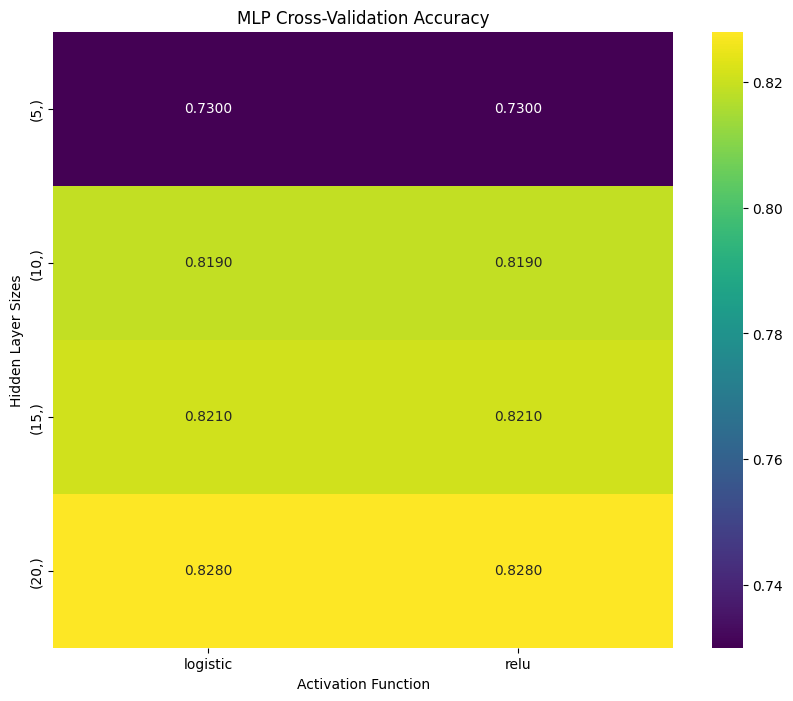

Best Parameters: {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': (20,)}
Best Cross-Validation Accuracy: 0.8280


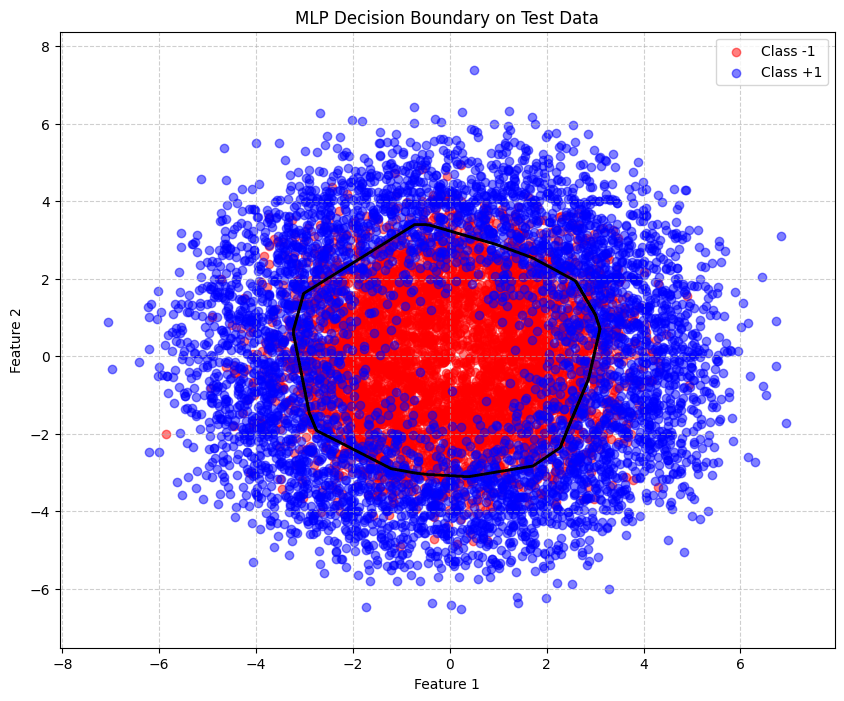

SVM Test Accuracy: 0.8316
Estimated Probability of Error: 0.1684
Classification Report:
               precision    recall  f1-score   support

          -1       0.84      0.83      0.83      5099
           1       0.82      0.84      0.83      4901

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



In [ ]:
mlp_model, mlp_best_params = train_mlp_with_cv(D_train, L_train)
mlp_test_accuracy, mlp_classification_report = test_mlp(mlp_model, D_test, L_test)

# Question 2

In [3]:
# Image feature vector calculation

img = Image.open('img1.jpg')
img_array = np.array(img)

height, width, _ = img_array.shape
row_indices, col_indices = np.indices((height, width))
red_values = img_array[:, :, 0] / 255.0
green_values = img_array[:, :, 1] / 255.0
blue_values = img_array[:, :, 2] / 255.0
features = np.stack([row_indices.flatten(), col_indices.flatten(), red_values.flatten(), green_values.flatten(), blue_values.flatten()], axis=1)

scaler = MinMaxScaler()
features_normalized = scaler.fit_transform(features)

In [4]:
# K-fold training of GMM

kf = KFold(n_splits=10, shuffle=True, random_state=42)
best_n_components = None
best_log_likelihood = -np.inf

for n_components in range(1, 11):
  log_likelihoods = []
  for train_idx, val_idx in kf.split(features_normalized):
    X_train, X_val = features_normalized[train_idx], features_normalized[val_idx]

    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X_train)

    log_likelihood = gmm.score(X_val)
    log_likelihoods.append(log_likelihood)

  avg_log_likelihood = np.mean(log_likelihoods)

  if avg_log_likelihood > best_log_likelihood:
    best_log_likelihood = avg_log_likelihood
    best_n_components = n_components

gmm = GaussianMixture(n_components=best_n_components, random_state=42)
gmm.fit(features_normalized)

GaussianMixture(n_components=10, random_state=42)

In [5]:
labels = gmm.predict(features_normalized)
labels_image = labels.reshape(height, width)

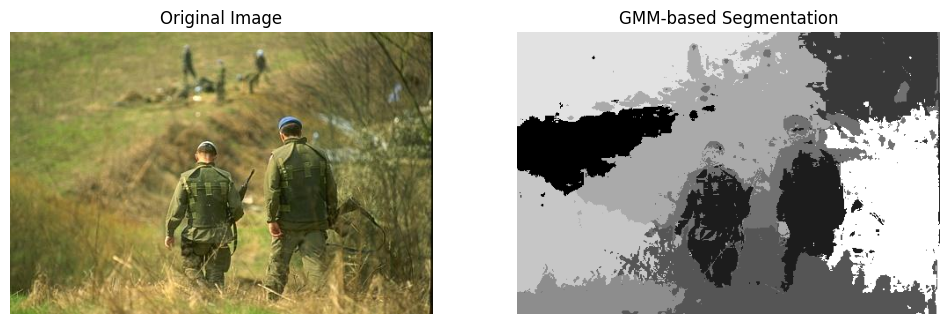

In [6]:
# Grayscale image segmentation

label_image_gray = np.uint8(255 * (labels_image - np.min(labels_image)) / (np.max(labels_image) - np.min(labels_image)))

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(label_image_gray, cmap='gray')
axes[1].set_title('GMM-based Segmentation')
axes[1].axis('off')

plt.show()

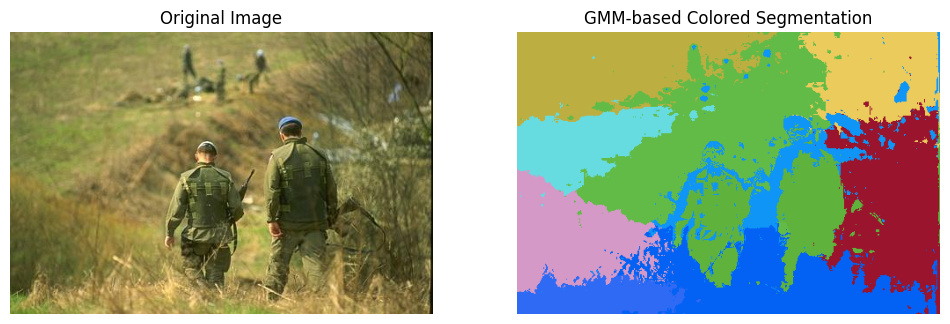

In [7]:
# Color image segmentation

unique_labels = np.unique(labels)
num_labels = unique_labels.size

np.random.seed(42)
palette = np.random.randint(0, 256, size=(num_labels, 3), dtype=np.uint8)

label_image_color = np.zeros((height, width, 3), dtype=np.uint8)
for label_idx, label in enumerate(unique_labels):
    label_image_color[labels_image == label] = palette[label_idx]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(label_image_color)
axes[1].set_title('GMM-based Colored Segmentation')
axes[1].axis('off')

plt.show()